<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/dp_hjb_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

- Compute exact solution for LQG
- Check possible semi-explicit formula by comparing with exact solution
- Check the computation of LQG by Q-learning and compare with exact solution

## Math formula for LQG

We consider control problem with controlled dynamic
$$ dX_t = b(t, X_t, m_t) dt + \sigma dW_t,$$
with value
$$v(t,x) = \inf_m \mathbb E^{t,x} \Big[
\int_t^T \ell (s, X_s, m_s) ds + g(X_T)
\Big].$$


With 
$$b(t, x, a) = a, \sigma = 1, \ell(s, x, a) = \frac 1 2 a^2, g(x) = \frac 1 2 x^2$$
we have explicit solution
$$v(t,x) = \frac{x^2}{2(1+T-t)} + \frac 1 2 \ln (1 + T-t).$$
Optimal solution can be given as feedback form of
$$a(t,x) = - \frac{x}{1+T-t}.$$
See detailed derivation 
[here](https://github.com/songqsh/foo1/blob/master/doc/170810.pdf)

## Check semi-explicit formula

We first calculate exact numeric value of $v(0,0)$ using the above math formula.

In [0]:
import numpy as np
import time

from tqdm import tqdm
import matplotlib.pyplot as plt

In [0]:
#configuration

TERM = 1.
SIGMA = 1.

def drift(t,x,a):
  return a

def term_cost(x):
  return x**2/2

def run_cost(t,x,a):
  return a**2/2



In [3]:
def exact_v(t,x):
  tau = TERM -t
  return (x**2/(1+tau)+np.log(1+tau))/2

print('>>>>>> the exact value at (0,0) is %f' %(exact_v(0,0)))

>>>>>> the exact value at (0,0) is 0.346574


One may think of the value function can be represented by
$$v(t,x) = - \ln  \mathbb E [\exp(-(x+ \sqrt{2} W_{T-t})^2)]$$
We can compute $v(0,0)$ with this formula by Monte-Carlo method, and then compare this with exact computed value in the above.

In [4]:
#one other possible value 
def other_val(t,x):
  var1 = np.random.normal(0,1,10000)
  var2 = x + np.sqrt(2*(TERM-t))*var1
  var3 = np.exp(-var2**2).mean()
  return -np.log(var3)

print('>>>>>>> the value at (0,0) computed by semi-explicit formula is %f' %(other_val(0,0)))
print('>>>>>>> while the value at (0,0) from the exact formula is %f' %(exact_v(0,0)))

>>>>>>> the value at (0,0) computed by semi-explicit formula is 0.807976
>>>>>>> while the value at (0,0) from the exact formula is 0.346574


## Computation by Q-learning

Controlled transition probability with $(\delta, h)$ for time and state mesh size is calculated by
$$p^h(x\pm h |t, x, a) = (b^\pm(t,x,a) h + \frac 1 2 \sigma^2) \frac \delta {h^2}$$
and
$$p^h(x|t,x,a) = 1 - (p(x+ h |t, x, a) + p(x- h |t, x, a)),$$
and the running cost is
$$\ell^h(t,x,a) = \ell(t,x,a)\cdot \delta.$$
We perform the Q-learning in this below.

In [0]:
#configurations

NUM = 5 #num of meshes in one unit state space

h = 1./NUM #mesh size in state space

n_time = np.int(2*TERM*SIGMA**2/h**2)+1 #t_space.size

del_t = TERM/(n_time-1) #time mesh size

t_space = np.arange(n_time)*del_t #time space

u_lim = (t_space.size -1)*h #upper limit of state space
l_lim = - u_lim #lower limit ...

s_space = np.arange(l_lim, u_lim+h, h) #state space

a_space = np.arange(5*l_lim, 5*u_lim+h, h) #action space

In [0]:
#one step move

del_ind_space = np.arange(-1, 2)

#inputs:
#state_ind: ranging from 0 to s_space.size-1
#del_ind: from del_ind_space
def next_state_ind(state_ind, del_ind):
  
  next_state_ind = state_ind + del_ind
  if next_state_ind > s_space.size - 1:
    next_state_ind = s_space.size - 1
  elif next_state_ind < 0:
    next_state_ind = 0
  
  return next_state_ind

In [0]:
#transition probability
#output is probability of del_ind_space

def transition_probability(t, x, a):
  tp = np.zeros(del_ind_space.shape)
  
  b_plus = np.max([0, drift(t,x,a)])
  b_minus = np.max([0, -drift(t,x,a)])
  
  tp[0] = del_t/h**2*(b_minus*h + SIGMA**2/2) #prob to -1
  tp[2] = del_t/h**2*(b_plus*h + SIGMA**2/2) #prob to +1
  tp[1] = 1 - tp[0] - tp[2] #prob to +0
  
  '''
  #correction on prob
  if tp[1] <0:
    
    tp = tp - tp[1]
    tp = tp/tp.sum()
  ''' 
    
  return tp

In [8]:
#q-table and state value initialization
s_val = np.zeros([t_space.size, s_space.size])
q_table = np.zeros([t_space.size, s_space.size, a_space.size])

print('>>>>> q_table size is %i' %(q_table.size))

>>>>> q_table size is 2430450


In [0]:
#q-table terminal setup
for i in range(s_space.size):
  for j in range(a_space.size):
    q_table[-1,i,j] = term_cost(s_space[i])

In [0]:
#sync q_table, s_val
def q_s_sync(t_ind, s_val, q_table):
  for i in range(s_space.size):
    s_val[t_ind, i] = np.min(q_table[t_ind,i])
    
q_s_sync(-1, s_val, q_table)

In [0]:
start_time = time.time()

In [12]:
#backward iteration
for i in tqdm(np.arange(t_space.size-2, -1, -1)):
  for j in np.arange(s_space.size):
    for k in np.arange(a_space.size):
      t_ = t_space[i]
      x_ = s_space[j]
      a_ = a_space[k]
      
      cost_ = run_cost(t_, x_, a_)*del_t
      
      tp_ = transition_probability(t_, x_, a_)
      
      for ii in range(del_ind_space.size):
        next_j = next_state_ind(j, del_ind_space[ii])
        cost_ += tp_[ii]*s_val[i+1, next_j]
      q_table[i,j,k] = cost_
      
  q_s_sync(i, s_val, q_table)

100%|██████████| 49/49 [00:54<00:00,  1.10s/it]


In [13]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 54.305761 seconds


In [14]:
print('>>>>>>>>>> the computed value at (0,0) by Q-learning is %f' %(s_val[0, int(s_space.size/2)]))
#s_space[int(s_space.size/2)]

>>>>>>>>>> the computed value at (0,0) by Q-learning is 0.372013


## Conclusion

In this below, we will graph values in a neighborhood of zero using three methods: exact solution, semi-explicit representation, q-learning. It tells us that Q-learning is close to exact solution, although its not effective enough.

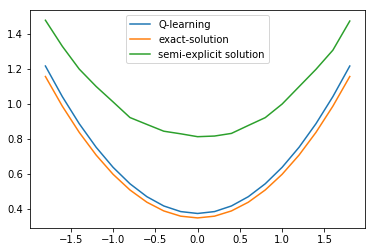

In [15]:
l_ind = 40
u_ind = 59

plt.plot(s_space[l_ind:u_ind], s_val[0, l_ind:u_ind], label = 'Q-learning')

exact_sol = [exact_v(0,x) for x in s_space]
plt.plot(s_space[l_ind:u_ind], exact_sol[l_ind:u_ind], label='exact-solution')

other_sol = [other_val(0,x) for x in s_space[l_ind:u_ind]]
plt.plot(s_space[l_ind:u_ind], other_sol, label = 'semi-explicit solution')

plt.legend()